<a href="https://colab.research.google.com/github/piyush5566/Behavioral-Intrusion-Detection-in-Network-Traffic/blob/master/cdx2009_pearson_correlation_label_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score

#three algorithms
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn import preprocessing
from pylab import rcParams
rcParams['figure.figsize']=14,8
RANDOM_SEED=42
LABELS=[False,True]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Data Preprocessing

In [ ]:
!unrar x "/content/drive/My Drive/Netwok_Security/ASNM-dataset.zip (Unzipped Files)/ASNM-CDX-2009.rar" "/content/drive/My Drive/Netwok_Security/ASNM-dataset.zip (Unzipped Files)/"

In [ ]:
data=(pd.read_csv("/content/drive/My Drive/Netwok_Security/ASNM-dataset.zip (Unzipped Files)/ASNM-CDX-2009.csv",sep=';',index_col='id')
      .select_dtypes(exclude=['object']))
data=data.drop([c for c in list(data) if data[c].nunique() is 1],axis=1)#dropping columns with number of unique values = 1

In [ ]:
data.head()

,label_2,SrcPort,DstPort,SrcIPInVlan,DstIPInVlan,InPkt1s10i[0],InPkt1s10i[1],InPkt1s10i[2],InPkt1s10i[3],InPkt1s10i[4],InPkt1s10i[5],InPkt1s10i[6],InPkt1s10i[7],InPkt1s10i[8],InPkt1s10i[9],InPkt4s10i[0],InPkt4s10i[1],InPkt4s10i[2],InPkt4s10i[3],InPkt4s10i[4],InPkt4s10i[5],InPkt4s10i[6],InPkt4s10i[7],InPkt4s10i[8],InPkt4s10i[9],InPkt8s10i[0],InPkt8s10i[1],InPkt8s10i[2],InPkt8s10i[3],InPkt8s10i[4],InPkt8s10i[5],InPkt8s10i[6],InPkt8s10i[7],InPkt8s10i[8],InPkt8s10i[9],InPkt32s10i[0],InPkt32s10i[1],InPkt32s10i[2],InPkt32s10i[3],InPkt32s10i[4],...,GaussProds4In[2],GaussProds4In[3],GaussProds8In[0],GaussProds8In[1],GaussProds8In[2],GaussProds8In[3],GaussProds8In[4],GaussProds8In[5],GaussProds8In[6],GaussProds8In[7],GaussProds1Out[0],GaussProds2Out[0],GaussProds2Out[1],GaussProds4Out[0],GaussProds4Out[1],GaussProds4Out[2],GaussProds4Out[3],GaussProds8Out[0],GaussProds8Out[1],GaussProds8Out[2],GaussProds8Out[3],GaussProds8Out[4],GaussProds8Out[5],GaussProds8Out[6],GaussProds8Out[7],GaussProds1All[0],GaussProds2All[0],GaussProds2All[1],GaussProds4All[0],GaussProds4All[1],GaussProds4All[2],GaussProds4All[3],GaussProds8All[0],GaussProds8All[1],GaussProds8All[2],GaussProds8All[3],GaussProds8All[4],GaussProds8All[5],GaussProds8All[6],GaussProds8All[7]
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,False,63637,5222,True,True,5,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,5,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.536381,27.932563,18.968168,1.861376,3.031384,3.257409,26.990536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.206032,16.347673,12.284234,17.460909,28.271599,39.854715,13.226058,30.142188,27.376107,65.213653,28.129521,98.002262,34.486082,26.990536,16.262570
2,False,2201,80,False,True,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,8,5,3,1,0,0,8,8,0,0,8,51,42,9,16,114,0,0,...,6.873797,26.227802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.393079,15.870392,27.447388,25.275107,26.156893,175.694074,16.349902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.164148,14.898874,17.778619,12.400587,35.642225,42.446332,10.750317,25.283971,25.283971,15.870392,175.667483,27.907473,62.828639,26.862012,14.797450
3,False,2201,80,False,True,1,3,0,2,0,2,0,1,0,2,6,3,2,0,0,0,0,1,12,20,9,2,0,1,32,68,4,17,0,0,12,121,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.658626,60.655334,27.447388,1.622057,6.634477,6.714250,24.494950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.169875,33.247735,15.335996,15.870392,61.517329,62.828639,12.236273,25.275107,26.156893,175.667483,27.907473,182.848444,26.254394,26.862012,14.797450
4,False,2202,443,False,True,1,2,0,1,0,2,0,0,0,0,4,2,0,0,0,0,1,10,14,43,6,0,0,11,57,33,16,5,0,0,17,111,0,0,0,...,17.204436,31.414356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.813228,22.921652,18.926762,24.760861,50.780670,94.965838,15.174157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.613480,32.042444,12.925019,14.570249,89.596237,42.162261,11.164318,25.275107,24.760861,25.046723,478.845737,99.885190,19.688286,31.250377,14.821825
5,False,2203,80,False,True,4,2,2,3,2,4,3,4,9,7,11,13,39,38,0,3,10,8,0,0,24,77,3,18,0,0,0,0,0,0,122,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.658626,60.655334,27.447388,1.622057,6.634477,6.714250,24.494950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.169875,33.247735,15.335996,15.870392,61.517329,62.828639,12.236273,25.275107,26.156893,175.667483,27.907473,182.848444,26.254394,26.862012,14.797450


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5771 entries, 1 to 5771
Columns: 839 entries, label_2 to GaussProds8All[7]
dtypes: bool(4), float64(331), int64(504)
memory usage: 36.8 MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.describe()

,SrcPort,DstPort,InPkt1s10i[0],InPkt1s10i[1],InPkt1s10i[2],InPkt1s10i[3],InPkt1s10i[4],InPkt1s10i[5],InPkt1s10i[6],InPkt1s10i[7],InPkt1s10i[8],InPkt1s10i[9],InPkt4s10i[0],InPkt4s10i[1],InPkt4s10i[2],InPkt4s10i[3],InPkt4s10i[4],InPkt4s10i[5],InPkt4s10i[6],InPkt4s10i[7],InPkt4s10i[8],InPkt4s10i[9],InPkt8s10i[0],InPkt8s10i[1],InPkt8s10i[2],InPkt8s10i[3],InPkt8s10i[4],InPkt8s10i[5],InPkt8s10i[6],InPkt8s10i[7],InPkt8s10i[8],InPkt8s10i[9],InPkt32s10i[0],InPkt32s10i[1],InPkt32s10i[2],InPkt32s10i[3],InPkt32s10i[4],InPkt32s10i[5],InPkt32s10i[6],InPkt32s10i[7],...,GaussProds4In[2],GaussProds4In[3],GaussProds8In[0],GaussProds8In[1],GaussProds8In[2],GaussProds8In[3],GaussProds8In[4],GaussProds8In[5],GaussProds8In[6],GaussProds8In[7],GaussProds1Out[0],GaussProds2Out[0],GaussProds2Out[1],GaussProds4Out[0],GaussProds4Out[1],GaussProds4Out[2],GaussProds4Out[3],GaussProds8Out[0],GaussProds8Out[1],GaussProds8Out[2],GaussProds8Out[3],GaussProds8Out[4],GaussProds8Out[5],GaussProds8Out[6],GaussProds8Out[7],GaussProds1All[0],GaussProds2All[0],GaussProds2All[1],GaussProds4All[0],GaussProds4All[1],GaussProds4All[2],GaussProds4All[3],GaussProds8All[0],GaussProds8All[1],GaussProds8All[2],GaussProds8All[3],GaussProds8All[4],GaussProds8All[5],GaussProds8All[6],GaussProds8All[7]
count,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,...,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000,5771.000000
mean,39220.685843,340.984925,7.046959,7.456247,7.514815,6.808525,7.348986,6.960319,6.873332,7.116271,6.897765,7.076243,28.826373,28.298388,27.755155,26.937273,26.690348,25.957893,25.461272,24.937099,24.465431,24.095304,57.122163,54.692428,52.648241,50.398371,48.560735,46.702824,45.122509,43.631606,42.354011,40.879744,214.861203,184.011263,160.699359,136.718246,134.384335,135.437879,127.670421,124.324207,...,43.893182,39.047172,1.689815,6.096798,4.480161,7.375319,8.256571,9.286250,7.869505,6.954884,25.062379,35.421374,27.178316,17.955402,23.314307,32.412449,21.621486,8.359402,25.426350,16.109169,14.608235,29.143210,31.714685,13.022221,8.076879,17.364551,28.308393,20.045328,24.094897,45.041043,52.997624,16.450495,22.062825,29.577259,118.589119,40.282891,112.217032,59.488651,32.538063,16.191687
std,24358.193471,725.021824,7.289772,9.367462,9.934251,9.687397,9.813364,9.831033,9.593184,9.726012,9.588769,9.519973,35.361750,38.203288,37.423533,37.221309,36.579421,36.351526,35.857015,35.286144,34.635057,34.029479,73.028810,74.131065,72.411303,70.609085,68.115799,65.945237,63.655243,61.238031,58.823777,55.883350,282.270950,249.987539,206.722176,148.989324,142.253173,142.261652,140.223401,135.006043,...,74.304741,51.674748,11.136287,44.110848,28.837308,44.781396,48.382762,56.014706,50.028247,35.936420,15.308178,28.168170,15.379327,28.228207,50.740281,43.373078,13.789949,19.000458,65.462950,57.718612,49.415400,61.292629,72.065714,34.748099,13.058834,6.004700,10.248739,9.288444,11.851015,20.022812,27.213690,8.678672,11.592764,20.182041,76.973307,60.324614,86.172839,52.455015,35.952925,6.978461
min,1032.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000

In [ ]:
#check any null value in data
data.isnull().values.any()

False

False    5727
True       44
Name: label_2, dtype: int64

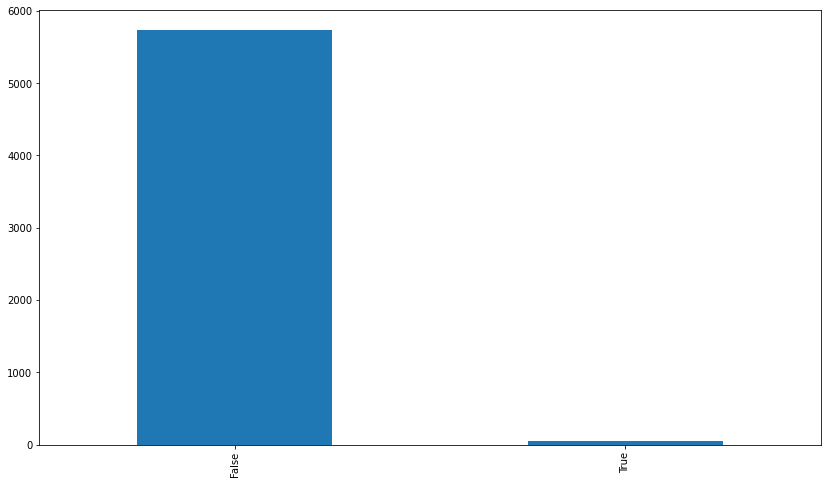

In [ ]:
#visualization of distribution of legitimate and buffer overflow attack in network flows
count_classes=pd.value_counts(data['label_2'])
count_classes.plot(kind='bar')
count_classes

PEARSON CORRELATION COEFFICIENT

We will use Pearson correlation coefficient to select the features mostly related with the column 'label_2', taking 0.3 as the threshold for selection.

In [ ]:
useful_data=data[(c for c in list(data) if data['label_2'].corr(data[c])>0.3)]
useful_data #11 columns selected

,label_2,PolyInd3ordOut[1],PolyInd5ordOut[5],PolyInd8ordOut[6],PolyInd8ordOut[8],PolyInd13ordOut[10],GaussProds4In[2],GaussProds2Out[0],GaussProds4Out[1],GaussProds4All[0],GaussProds8All[1]
id,,,,,,,,,,,
1,False,-35.000000,7.410509,629.499612,87.346347,-53.566841,0.000000,27.932563,3.031384,17.460909,27.376107
2,False,-95.571429,531.010539,-8361.421022,-1349.653131,3126.615066,6.873797,15.870392,26.156893,12.400587,25.283971
3,False,-438.000000,156.808352,2637.539433,392.817837,-482.794129,0.000000,60.655334,6.634477,15.870392,26.156893
4,False,-84.000000,664.205100,-2226.988110,-363.411860,945.491280,17.204436,22.921652,50.780670,14.570249,24.760861
5,False,-438.000000,156.808352,2637.539433,392.817837,-482.794129,0.000000,60.655334,6.634477,15.870392,26.156893
...,...,...,...,...,...,...,...,...,...,...,...
5767,False,68.000000,69.108726,60.975525,-5.735406,0.007954,0.000000,1.622057,0.000000,1.648648,0.000000
5768,False,68.000000,69.108726,60.975525,-5.735406,0.007954,0.000000,1.622057,0.000000,1.648648,0.000000
5769,False,68.000000,69.108726,60.975525,-5.735406,0.007954,0.000000,1.622057,0.000000,25.275107,0.000000


0.007682905535184215


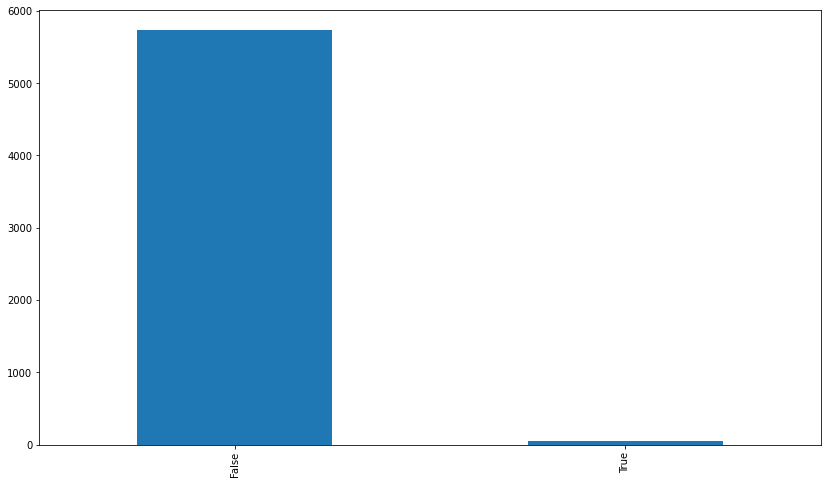

In [ ]:
#visualization of distribution of legitimate and buffer overflow attack in network flows
count_classes=pd.value_counts(useful_data['label_2'])
count_classes.plot(kind='bar')
outlier_fraction=count_classes[1]/count_classes[0]#calculating fraction of outliers
print(outlier_fraction)

In [ ]:
#dividing data into X and Y
columns=useful_data.columns.tolist()
columns=[c for c in columns if c not in ["label_2"]]
target="label_2"
state=np.random.RandomState(42)
X=useful_data[columns]
# X=preprocessing.normalize(useful_data[columns])
Y=useful_data[target].astype(int)
print(X.shape)
print(Y.shape)

(5771, 10)
(5771,)


In [ ]:
from sklearn.model_selection import train_test_split

train_x,test_x,y_train,y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
train_x,cv_x,y_train,y_cv = train_test_split(train_x, y_train, test_size=0.25, random_state=42)

In [ ]:
print('Training Shape : ',train_x.shape)
print('Cross-Validation Shape : ',cv_x.shape)
print('Test Shape : ',test_x.shape)





Training Shape :  (3246, 10)
Cross-Validation Shape :  (1082, 10)
Test Shape :  (1443, 10)


##Isolation Forest, Local Outlier Factor and Support Vector Machine

In [ ]:
#preparing a dictionary of 3 classifiers
classifiers={
    "Isolation Forest":IsolationForest(n_estimators=100,max_samples=len(X),contamination=outlier_fraction,random_state=state,verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20,algorithm='auto',leaf_size=30,metric='minkowski',p=2,metric_params=None,
                                              contamination=outlier_fraction,novelty=True),
    "Support Vector Machine":OneClassSVM(kernel='rbf',degree=3,gamma=0.1,nu=0.05,max_iter=-1)
}

In [ ]:
n_outliers=count_classes[0]
for i,(clf_name,clf) in enumerate(classifiers.items()):
    if clf_name=='Local Outlier Factor':
        clf.fit(train_x)
        y_pred_cv = clf.predict(cv_x)
        y_pred_test = clf.predict(test_x)
        scores_prediction=clf.negative_outlier_factor_
    elif clf_name=='Support Vector Machine':
        clf.fit(train_x)
        y_pred_cv=clf.predict(cv_x)
        y_pred_test = clf.predict(test_x)
    else:
        clf.fit(train_x)
        scores_prediction=clf.decision_function(X)
        y_pred_cv=clf.predict(cv_x)
        y_pred_test = clf.predict(test_x)
    y_pred_cv[y_pred_cv==1]=0
    y_pred_cv[y_pred_cv==-1]=1

    y_pred_test[y_pred_test==1]=0
    y_pred_test[y_pred_test==-1]=1

    n_errors_cv=(y_pred_cv!=y_cv).sum()
    n_errors_test = (y_pred_test!=y_test).sum()
    print()
    print(clf_name.upper())
    print()
    print("Number of wrong predictions for Cross-Validation set : {}".format(n_errors_cv))
    print("Number of wrong predictions for Test set : {}".format(n_errors_test))
    print("\nCross-Validation Accuracy Score : ")
    print(accuracy_score(y_cv,y_pred_cv))
    print("\nTest Classification report : ")
    print(classification_report(y_test,y_pred_test))
    #pd.DataFrame(y_pred,y_cv).to_csv("output"+clf_name+".csv")

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:281: UserWarning: max_samples (5771) is greater than the total number of samples (3246). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))



ISOLATION FOREST

Number of wrong predictions for Cross-Validation set : 8
Number of wrong predictions for Test set : 14

Cross-Validation Accuracy Score : 
0.9926062846580407

Test Classification report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1431
           1       0.33      0.17      0.22        12

    accuracy                           0.99      1443
   macro avg       0.66      0.58      0.61      1443
weighted avg       0.99      0.99      0.99      1443


LOCAL OUTLIER FACTOR

Number of wrong predictions for Cross-Validation set : 14
Number of wrong predictions for Test set : 27

Cross-Validation Accuracy Score : 
0.9870609981515711

Test Classification report : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1431
           1       0.00      0.00      0.00        12

    accuracy                           0.98      1443
   macro avg       0.50      0.49 

In [ ]:
X=data[columns]
# X=preprocessing.normalize(useful_data[columns])
Y=data[target].astype(int)

#KMEANS

In [ ]:
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=2)
kmeans.fit(train_x)
y_pred_cv=kmeans.predict(cv_x)
y_pred_test=kmeans.predict(test_x)
print('KMEANS')
print()
print('Cross-Validation Accuracy : ',accuracy_score(y_cv,y_pred_cv))
print('Test Classification Report\n',classification_report(y_test,y_pred_test))

KMEANS

Cross-Validation Accuracy :  0.9916820702402958
Test Classification Report
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1431
           1       0.39      0.58      0.47        12

    accuracy                           0.99      1443
   macro avg       0.69      0.79      0.73      1443
weighted avg       0.99      0.99      0.99      1443

